In [61]:
# Import libraries
import pandas as pd
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import math
from more_itertools import consecutive_groups
from operator import itemgetter
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
warnings.filterwarnings('ignore')

In [70]:
# Moving average function
# Moving average is computed by convolving a kernel of size=window
# and kernel elements of 1/window_size
def ma(array, window=1):  # Moving average
     return np.convolve(array[0], np.ones((1,window))[0]/window, mode='same').reshape(1,array.shape[1])

def remove_index_sequences(indecies):
    temp=[list(group) for group in consecutive_groups(indecies)]
    clean_list=[]
    for grp in temp:
        clean_list.append(grp[0])
    return clean_list
# Function to detect periodicity and anomaly
# dataframe:		input data frame
# mov_avg_window:	window size for moving average (int)
# threshold:		threshold for trend deviation [0,1] 

In [79]:
np.random.seed(41)

t=np.linspace(0,120,121)

freq=1/4

scale=np.random.uniform(low=0.0, high=1.0, size=len(t))*abs(np.cos(t))+0.01

# time_series=scale*np.sin(2*np.pi*freq*t)-0.00005*(2*t-40)**2+5
# time_series[105:]=0
# time_series[21]=0
# time_series[43:52]=time_series[42]

# time_series=scale*np.sin(2*np.pi*freq*t)+0.05*(t-40)+5
# time_series[104:]=0
# time_series[21]=8
# time_series[43:52]=time_series[42]+0.1*time_series[43:52]

scale=t/10
time_series=scale*np.sin(2*np.pi*freq*t)
time_series[45:60]*=0.1
time_series+=0.0000001

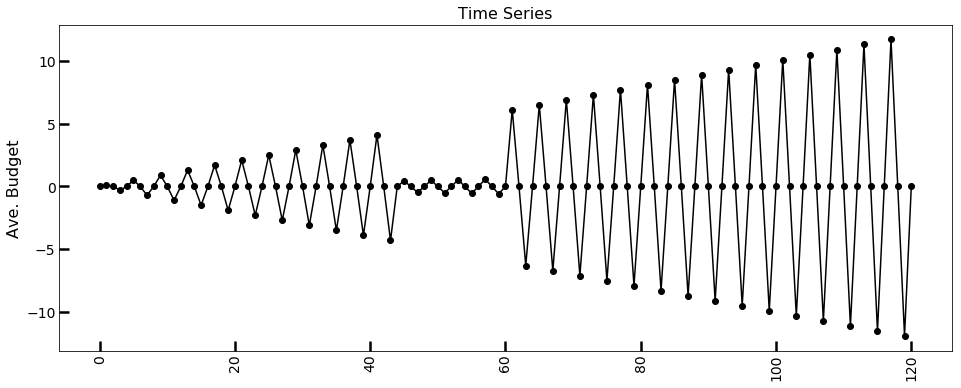

In [72]:
plt.figure(figsize=(16,6))
plt.cla()
plt.plot(t, time_series,'k-o')
plt.xticks(rotation='vertical');
plt.tick_params(direction='in', length=10, width=2.5, colors='k',
                           grid_color='k', grid_alpha=1, labelsize=14)
plt.ylabel('Ave. Budget', fontsize=16)
plt.title('Time Series', fontsize=16);

In [80]:
period=[] # List to save periods of all advertisers
flags=[]  # List to save indecied of anomalies of all advertisers 

threshold=1.25
i=0

mov_avg_window=4
ma_window=4

# Create a time series from the dataframe row

# Remove heading zeros --> Heading zeros mean the business wasn't a client yet
index=(time_series != 0).argmax()
time_series=time_series[index:].reshape(1,-1)

hold_it=time_series.copy()

# Remove trailing zeros --> Means the client really left
# we remove those zeros so that they wouldn't contaminate 
# the calculation of seasonality period.
time_series[0]=time_series[0][::-1]
index=(time_series != 0).argmax()
time_series=time_series[0][index:].reshape(1,-1)
time_series[0]=time_series[0][::-1]

# Adjust the moving average window size if time series
# has fewer points than mov_avg_window
if time_series.shape[1] < mov_avg_window:
    ma_window=time_series.shape[1]

# Remove trend from the time series using moving average    
ts_no_trend=time_series-ma(time_series, window=ma_window)

################################################################
# Seasonality detection. Refer to header for more information. #
################################################################
# Next largest power of 2        
nfft=1<<(time_series.shape[1]-1).bit_length()

# Performing FFT and rescaling
y=np.fft.fft(ts_no_trend, n=nfft)
y=abs(y**2)
y=(y-y.min())
y=y/y.max() # Power spectrum

# Creating the half frequency range
freq_ts=(np.linspace(0,nfft/2,int(nfft/2)) *1/float(nfft))
freq_ts=freq_ts.reshape(-1,1)

y=y[0][0:int(nfft/2)].reshape(1,-1).T # Throwing away the second half

# Saving the period
if (1/freq_ts[ np.argmax(y) ])[0] != np.inf: 
    period.append( math.ceil((1/freq_ts[ np.argmax(y) ])[0]) )
else:
    period.append(1000) # Arbitrary large number if no periodicity

# Once we're done with period calculation, put the trailing zeros back
time_series=hold_it.copy()

################################################################
# Detecting deviation from periodicity #########################
################################################################

# Get the locations of the peaks in the time series
peaks=scipy.signal.find_peaks(time_series[0])
peaks=peaks[0] # Reshape

troughs=scipy.signal.find_peaks(-time_series[0])
troughs=troughs[0]

temp_flags=[] # Saves the locations of anomalies for a given time series.

# Loop through the list of peaks and see if there are any two 
# consecutive peaks that are apart more than twice the period.	
#print(len(peaks) )
for j in range(1,len(peaks)):
   # print((peaks[j]-peaks[j-1])/period[i])
    if ( (peaks[j]-peaks[j-1])/period[i] >= 1.5 ):
        temp_flags.append(peaks[j-1])

# Check the distance of the last peak anf the last point in the time series.
# If the budget was zero for sometime at the end, then this will detect it.
if (time_series.shape[1]-peaks[-1])/period[i] >= 2:
        temp_flags.append(peaks[-1])

################################################################
# Detecting deviation from trend ###############################
################################################################
if len(time_series[0]) <= period[i]:
    decomposed=seasonal_decompose(time_series[0], freq=len(time_series[0])-1)
else:
    decomposed=seasonal_decompose(time_series[0], freq=period[i])
trend=decomposed.trend
trend[0]=0
trend[-1]=0

# Returns NaN values occasionally
smoothed=lowess(endog=trend,exog=range(0,len(trend)), frac=0.75, it=3,return_sorted=False )
smoothed2=smoothed.copy()
smoothed = abs(smoothed-time_series[0])
if np.isnan(smoothed).sum() != 0: # Check is there are in fact nan values
    nan_indecies=np.argwhere(np.isnan(smoothed)) # If yes, find their indecies
    for ind in nan_indecies: # interpolate
        index_ind=ind[0]
        if index_ind==0:
            smoothed[0]=smoothed[1]
        if index_ind==len(smoothed)-1:
            smoothed[-1]=smoothed[-2]
        else:
            smoothed[index_ind]=0.5*(smoothed[index_ind+1]+smoothed[index_ind-1])

for j in range(0,len(smoothed)): # Wherever the there is a "huge" difference between the trend and signal
    if smoothed[j] > threshold*smoothed.std():
        temp_flags.append(j)

# Getting unique values
my_set=set(temp_flags)
temp_flags=list(my_set)
temp_flags=sorted(temp_flags)
temp_flags=remove_index_sequences(temp_flags)
flags.append(temp_flags)

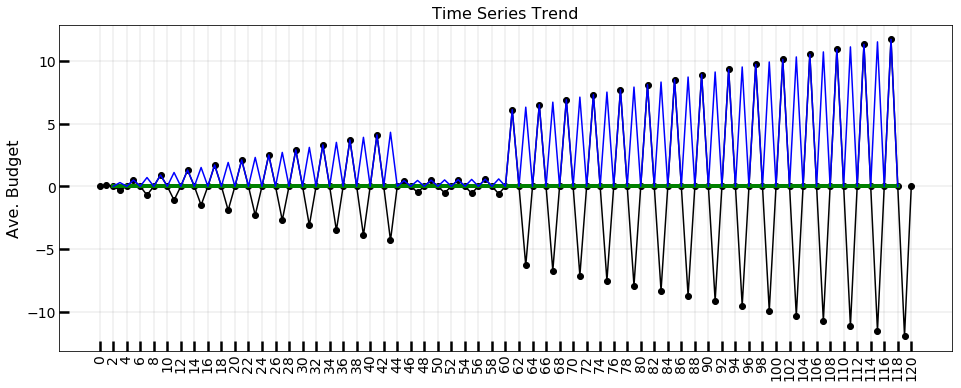

In [74]:
plt.figure(figsize=(16,6))
plt.cla()
plt.plot(t, time_series[0],'k-o')
#plt.plot(t, trend,'r-')
#plt.plot(t, smoothed, 'g')
plt.plot(t, smoothed2, 'g', linewidth=4)
#plt.plot(t, smoothed3, 'y')
plt.plot(t, abs(time_series[0]-smoothed2), 'b')
plt.xticks(ticks=t[::2],rotation='vertical');
plt.tick_params(direction='in', length=10, width=2.5, colors='k',
                           grid_color='k', grid_alpha=1, labelsize=14)
plt.grid(color='grey', linestyle='-', linewidth=0.2)
plt.ylabel('Ave. Budget', fontsize=16)
plt.title('Time Series Trend', fontsize=16);

In [88]:
extermas=np.append(peaks,troughs)
extermas.sort()

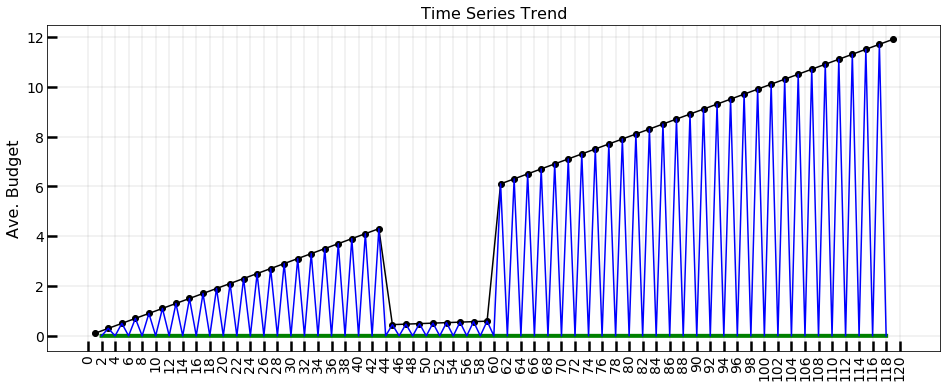

In [90]:
plt.figure(figsize=(16,6))
plt.cla()
plt.plot(extermas, abs(time_series[0][extermas]),'k-o')
#plt.plot(t, trend,'r-')
#plt.plot(t, smoothed, 'g')
plt.plot(t, smoothed2, 'g', linewidth=4)
#plt.plot(t, smoothed3, 'y')
plt.plot(t, abs(time_series[0]-smoothed2), 'b')
plt.xticks(ticks=t[::2],rotation='vertical');
plt.tick_params(direction='in', length=10, width=2.5, colors='k',
                           grid_color='k', grid_alpha=1, labelsize=14)
plt.grid(color='grey', linestyle='-', linewidth=0.2)
plt.ylabel('Ave. Budget', fontsize=16)
plt.title('Time Series Trend', fontsize=16);

In [8]:
period

[4]

In [9]:
np.argmax(y)

32

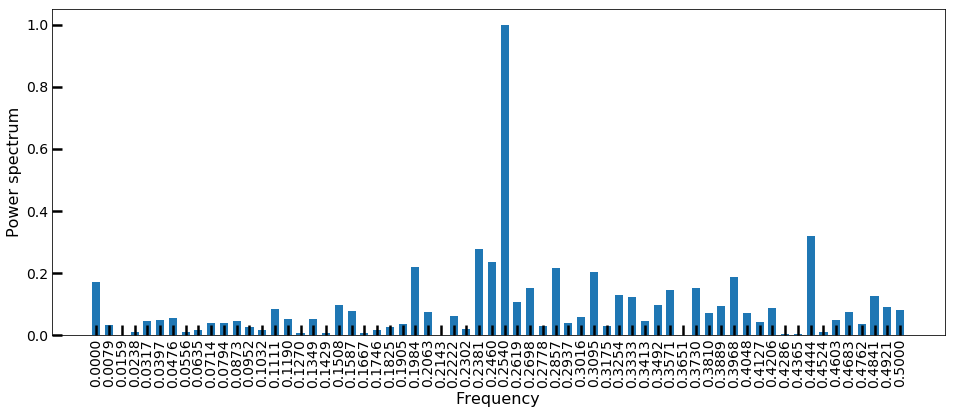

In [28]:
plt.figure(figsize=(16,6))
plt.cla()
plt.bar(freq_ts.T[0],y.T[0], width=0.005)
plt.xticks(ticks=freq_ts.T[0], rotation='vertical');
#plt.yscale('log')
plt.tick_params(direction='in', length=10, width=2.5, colors='k',
                           grid_color='k', grid_alpha=1, labelsize=14)
plt.ylabel('Power spectrum', fontsize=16);
plt.xlabel('Frequency', fontsize=16);

In [78]:
peaks

array([  1,   5,   9,  13,  17,  21,  25,  29,  33,  37,  41,  45,  49,
        53,  57,  61,  65,  69,  73,  77,  81,  85,  89,  93,  97, 101,
       105, 109, 113, 117], dtype=int64)